# `Progetto Text Mining`

**Autori:** Silvia Bordogna, Stefano Daraio <br>
**Obiettivo:** applicare un modello di classificazione su dataset di recensioni Amazon

In [89]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import itertools
import gzip
import joblib

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import preprocessing, metrics

import xgboost as xgb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\silvia.bordogna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\silvia.bordogna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\silvia.bordogna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**`Import`**

In [ ]:
path = 'C:/Users/silvia.bordogna/Documents/Uni/text_mining_and_search/Text Mining Project/'

In [64]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [65]:
df_video = getDF(path + 'reviews_Amazon_Instant_Video_5.json.gz')
df_auto = getDF(path + 'reviews_Automotive_5.json.gz')
df_beauty = getDF(path + 'reviews_Beauty_5.json.gz')
df_clothes = getDF(path + 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
df_music = getDF(path + 'reviews_Digital_Music_5.json.gz')
df_instruments = getDF(path + 'reviews_Digital_Music_5.json.gz')
df_office = getDF(path + 'reviews_Office_Products_5.json.gz')
df_pet = getDF(path + 'reviews_Pet_Supplies_5.json.gz')
df_home = getDF(path + 'reviews_Tools_and_Home_Improvement_5.json.gz')
df_toys = getDF(path + 'reviews_Toys_and_Games_5.json.gz')

Unione dati

In [69]:
i = 0
for dt in [df_video, df_auto, df_beauty, df_clothes, df_music, df_instruments, df_office, df_pet, df_home, df_toys]:
    dt['y'] = i
    i += 1
df = pd.concat(tot_df)
n_labels = i

Numero totale recensioni

In [71]:
len(df)

1177357

Selezione variabili di interesse (review e categoria)

In [76]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'y'],
      dtype='object')

In [74]:
data = df[['reviewText','y']]
data['reviewText'].head()

0    I had big expectations because I love English ...
1    I highly recommend this series. It is a must f...
2    This one is a real snoozer. Don't believe anyt...
3    Mysteries are interesting.  The tension betwee...
4    This show always is excellent, as far as briti...
Name: reviewText, dtype: object

Frequenze per categoria

In [75]:
pd.crosstab(index=data["y"], columns="count")  

col_0,count
y,
0,37126
1,20473
2,198502
3,278677
4,64706
5,64706
6,53258
7,157836
8,134476


**`Text preprocessing`**

Rimozione punteggiatura

In [77]:
data['reviewText'] = data['reviewText'].str.replace('[^\w\s]','')
data['reviewText'].head()

c:\users\silvia.bordogna\appdata\local\continuum\anaconda2\envs\ilab\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    I had big expectations because I love English ...
1    I highly recommend this series It is a must fo...
2    This one is a real snoozer Dont believe anythi...
3    Mysteries are interesting  The tension between...
4    This show always is excellent as far as britis...
Name: reviewText, dtype: object

Lower case

In [79]:
data['reviewText'] = data['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['reviewText'].head()

c:\users\silvia.bordogna\appdata\local\continuum\anaconda2\envs\ilab\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    i big expectations i love english tv particula...
1    i highly recommend series it must anyone yearn...
2    this one real snoozer dont believe anything re...
3    mysteries interesting the tension robson tall ...
4    this show always excellent far british crime m...
Name: reviewText, dtype: object

Rimozione stop words

In [78]:
stop = stopwords.words('english')
data['reviewText'] = data['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['reviewText'].head()

c:\users\silvia.bordogna\appdata\local\continuum\anaconda2\envs\ilab\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    I big expectations I love English TV particula...
1    I highly recommend series It must anyone yearn...
2    This one real snoozer Dont believe anything re...
3    Mysteries interesting The tension Robson tall ...
4    This show always excellent far british crime m...
Name: reviewText, dtype: object

Lemmatization

In [20]:
data['reviewText'] = data['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['reviewText'].head()

c:\users\silvia.bordogna\appdata\local\continuum\anaconda2\envs\ilab\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    big expectation love english tv particular inv...
1    highly recommend series must anyone yearning w...
2    one real snoozer dont believe anything read he...
3    mystery interesting tension robson tall blond ...
4    show always excellent far british crime myster...
Name: reviewText, dtype: object

Document Term Matrix

In [21]:
tfidf = TfidfVectorizer(max_features=10000, analyzer='word',ngram_range=(1,1))
train_vect = tfidf.fit_transform(my_data['reviewText'])

Si e' scelto di utilizzare TfidfVectorizerIl per assegnare un peso alle parole in base a tf-idf. Inoltre per motivi computazionali si e' scelto di tenere solo le prime 10000 feature in ordine di significativita'. Per lo stesso motivo si e' scelto di valutare solo 1-gram.

In [23]:
y = data.y

Salvataggio risultato pre processing

In [90]:
joblib.dump([train_vect, y], 'feature.joblib')
#feature = joblib.load('feature.joblib')
#train_vect = feature[0]
#y = feature[1]

['feature.joblib']

**`Classification con xgboost`**

Train/Test

In [37]:
x_train, x_test, y_train, y_test = train_test_split(train_vect, y, test_size=0.1, random_state=1)

Si e' scelto di usare un modello xgboost

Trasformazione dati nel formato richiesto dalla funzione

In [39]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

c:\users\silvia.bordogna\appdata\local\continuum\anaconda2\envs\ilab\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [40]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1059621, 10000)
(117736, 10000)
(1059621,)
(117736,)


Parametri algoritmo

In [83]:
param={}
param['max_depth']= 4  # depth of tree -6
param['min_child_weight']= 5.0
param['eta'] = 0.3      # shrinkage parameter -0.5
param['silent'] = 1     # not silent
param['objective'] = 'multi:softmax' #multi:softprob for prob vector
#param['nthread'] = 7 # Number of threads used
param['eval_metric'] = 'mlogloss' # 'auc' 
param['num_class'] = n_labels
param['verbose_eval'] = 10

plst = param.items()
print(param)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
#evallist = [(dtrain, 'train')]

{'max_depth': 4, 'min_child_weight': 5.0, 'eta': 0.3, 'silent': 1, 'objective': 'multi:softmax', 'eval_metric': 'mlogloss', 'num_class': 10, 'verbose_eval': 10}


Per ragioni computazionali si e' scelto di dare un limite alla profondita' del modello con un numero massimo di 5 figli.

In [47]:
%%time
#TRAINING
bst100 = xgb.train(param,dtrain,
    evals = evallist,
    num_boost_round=150, #3000,
    early_stopping_rounds=10
)

[0]	train-mlogloss:1.71977	eval-mlogloss:1.71818
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.4998	eval-mlogloss:1.49929
[2]	train-mlogloss:1.35247	eval-mlogloss:1.35197
[3]	train-mlogloss:1.2449	eval-mlogloss:1.24507
[4]	train-mlogloss:1.16046	eval-mlogloss:1.16045
[5]	train-mlogloss:1.09521	eval-mlogloss:1.09583
[6]	train-mlogloss:1.04119	eval-mlogloss:1.04187
[7]	train-mlogloss:0.996916	eval-mlogloss:0.997832
[8]	train-mlogloss:0.959283	eval-mlogloss:0.960297
[9]	train-mlogloss:0.926956	eval-mlogloss:0.928025
[10]	train-mlogloss:0.899357	eval-mlogloss:0.900343
[11]	train-mlogloss:0.874532	eval-mlogloss:0.876032
[12]	train-mlogloss:0.852853	eval-mlogloss:0.854599
[13]	train-mlogloss:0.83287	eval-mlogloss:0.834651
[14]	train-mlogloss:0.815535	eval-mlogloss:0.817334
[15]	train-mlogloss:0.799654	eval-mlogloss:0.801637
[16]	train-mlogloss:0.785286	eval-mlogloss:0

Salvataggio classifier

In [56]:
import pickle
classifier = bst100
filename = 'classifier.sav'
pickle.dump(classifier, open(filename, 'wb'))

**`Test`**

Creo funzione per stampare matrice di confusione

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Confusion matrix, without normalization


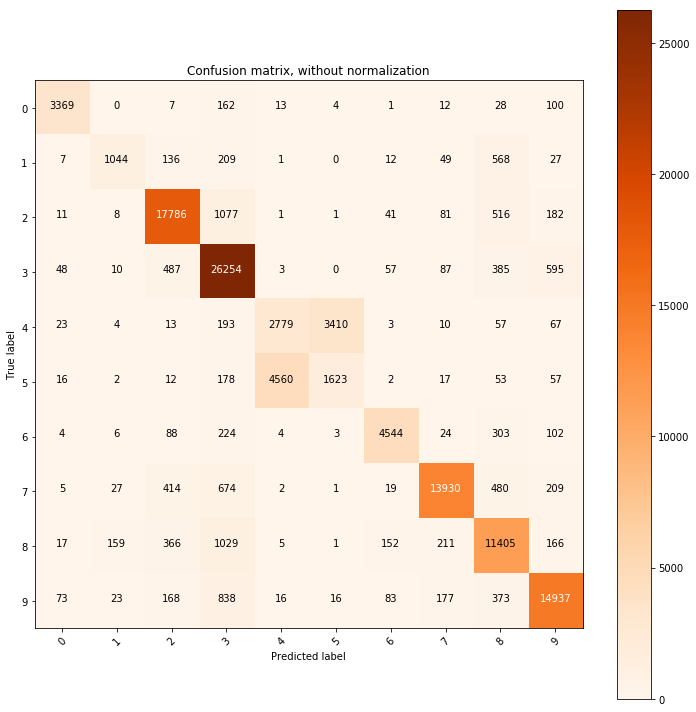

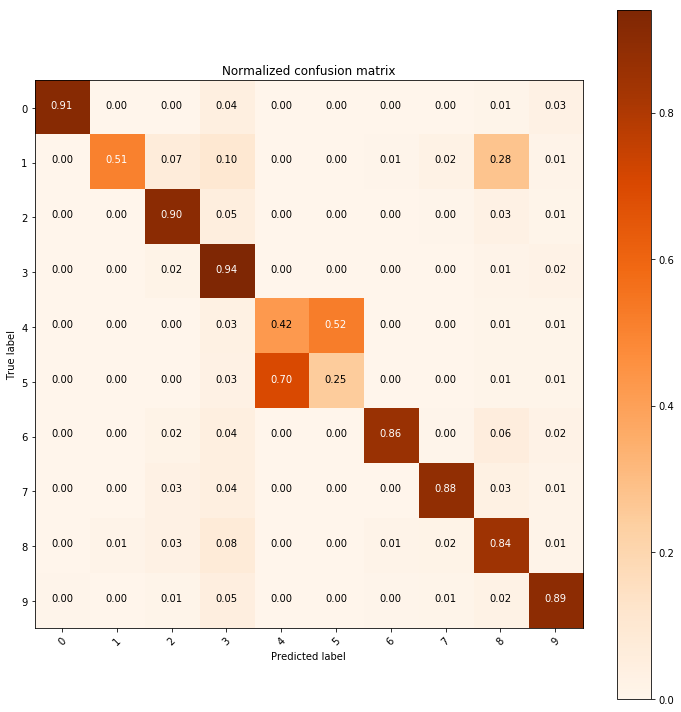

RF, Count Vectors:  0.8295763402867432
Wall time: 1.46 s


In [53]:
%%time

predictions = bst100.predict(dtest, ntree_limit=bst100.best_ntree_limit, output_margin=True) 
best_pred = np.asarray([np.argmax(line) for line in predictions])

#confusion matrix: categories
categories=set(y_test)
categories=sorted(categories)
print(categories)

#categories = sorted(samplesize.index)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=categories,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=categories, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy =metrics.accuracy_score(best_pred, y_test)
print("RF, Count Vectors: ", accuracy)

In [61]:
print(classification_report(y_test, best_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3696
           1       0.81      0.51      0.63      2053
           2       0.91      0.90      0.91     19704
           3       0.85      0.94      0.89     27926
           4       0.38      0.42      0.40      6559
           5       0.32      0.25      0.28      6520
           6       0.92      0.86      0.89      5302
           7       0.95      0.88      0.92     15761
           8       0.80      0.84      0.82     13511
           9       0.91      0.89      0.90     16704

   micro avg       0.83      0.83      0.83    117736
   macro avg       0.78      0.74      0.76    117736
weighted avg       0.83      0.83      0.83    117736



L'accuracy complessiva del modello e' di 83%. 

7 su 10 classi riportano valori di precision e recall maggiori all'80%.

Si nota che le classi muisc e instruments sono spesso confuse, probabilmente dovuto alla somiglianza dei termini usati nelle due classi. 

Inoltre la classe auto non riporta buone performance, probabilmente dovuto al fatto che si tratta di una classe sottorappresentata nel dataset. In particolare essa riporta una recall bassa, ovvero solo la meta' delle recensioni appartenenti alla categoria sono state correttamente assegnate, mentre l'altra meta' e' stata assegnata ad altre classi, in particolare home.  Questo potrebbe essere stato generato da class imbalance.